.. meta::
   :description: Using the responsible AI toolbox to build workflows.

> Copyright (c) 2022 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 



# Building a Workflows for Cross Validation and Adversarial Robustness
This notebook demonstrates how the to build [workflows]() for scalable experimentation.  Two basic workflows will be demonstrated:

- Cross-Validation Workflow: Demonstrates how to build scalable cross validation training workflow.
- Robustness Curve Workflow: Demonstrates how to build scalable robustness testing for each of the models trained in the "Cross-Validation Workflow"

If you haven't already, follow the steps at the beginning of the previous tutorial to install the rAI-toolbox and create a Jupyter notebook called `ImageNet-Concept-Probing.ipynb`. You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.

## Imports

In [1]:
from collections import defaultdict
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch as tr

In [2]:
# Hydra and hydra-zen
from hydra.core.config_store import ConfigStore
from hydra_zen import MISSING, builds, instantiate, load_from_yaml, make_config

# Lightning
from pytorch_lightning import LightningModule, Trainer

# sklearn and torch
from sklearn.model_selection import StratifiedKFold
from torch import Tensor, nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# rAI-toolbox
from rai_toolbox import evaluating
from rai_toolbox._typing import Partial
from rai_toolbox.mushin.lightning import HydraDDP, MetricsCallback
from rai_toolbox.mushin.workflows import (
    MultiRunMetricsWorkflow,
    RobustnessCurve,
    multirun,
)


## Experiment Functions and Classes

In [3]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 10, 3),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

In [4]:
def split_dataset(dataset: MNIST, n_splits: int, fold: int) -> Tuple[Subset, Subset]:
    """Provide training and validation splits using `sklearn.model_selection.StratifiedKfold`"""

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 49)
    train_indices, val_indices = list(kfold.split(range(len(dataset)), dataset.targets))[fold]
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

In [5]:
class StandardModule(LightningModule):
    def __init__(
        self,
        *,
        model: nn.Module,
        dataset: MNIST,
        optimizer: Optional[Partial[Optimizer]] = None,
        perturber = None,
        fold: int = 0,
        n_splits: int = 5,
        batch_size: int = 100,
        num_workers: int = 4,
    ) -> None:
        super().__init__()
        self.dataset = dataset
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.perturber = perturber
        self.n_splits = n_splits
        self.fold = fold
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Metrics
        self.acc_metric = Accuracy()
        if self.perturber:
            self.clean_acc_metric = Accuracy()

    def forward(self, data: Tensor) -> Tensor:
        return self.model(data)

    def train_dataloader(self) -> DataLoader:
        train_dataset, _ = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        _, val_dataset = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def configure_optimizers(self) -> Optional[Optimizer]:
        if self.optimizer:
            return self.optimizer(self.model.parameters())
        return None

    def _step(self, batch, stage: str) -> Tensor:
        data_orig, target = batch

        if self.perturber:
            with tr.no_grad():
                output = self.model(data_orig)
                loss = self.criterion(output, target)
                acc = self.clean_acc_metric(output, target)
                self.log(f"{stage}_clean_accuracy", acc)

            data, adv_loss = self.perturber(
                model=self.model, data=data_orig, target=target
            )
            self.log(f"{stage}_adversarial_loss", adv_loss.mean().item())

        else:
            data = data_orig

        output = self.model(data)
        loss = self.criterion(output, target)
        acc = self.acc_metric(output, target)
        self.log(f"{stage}_loss", loss)
        self.log(f"{stage}_accuracy", acc)
        return loss

    def training_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "test")

## hydra-zen Configuration

In [6]:
Augmentations = builds(transforms.Compose, [builds(transforms.RandomCrop, size=28, padding=4), builds(transforms.ToTensor)])
TrainDataset = builds(MNIST, root="${data_dir}", train=True, transform=Augmentations)
TestDataset = builds(MNIST, root="${data_dir}", train=False, transform=builds(transforms.ToTensor))
ConvModelCfg = builds(ConvModel)
LinearModelCfg = builds(LinearModel)
Optim = builds(tr.optim.SGD, lr=0.1, zen_partial=True)

from rai_toolbox.optim import L2ProjectedOptim, LinfProjectedOptim
from rai_toolbox.perturbations import gradient_ascent
L2PGD = builds(L2ProjectedOptim, zen_partial=True)
LinfPGD = builds(LinfProjectedOptim, zen_partial=True)

def lr_for_pgd(epsilon, num_steps):
    return 2.5 * epsilon / num_steps

Perturber = builds(
    gradient_ascent,
    optimizer="${optimizer}",
    epsilon="${epsilon}",
    steps="${steps}",
    lr=builds(lr_for_pgd, "${epsilon}", "${steps}"),
    zen_partial=True,
    populate_full_signature=True
)

PLModule = builds(
    StandardModule,
    model="${model}",
    fold="${fold}",
    n_splits="${n_splits}",
    dataset=TrainDataset,
    optimizer=Optim,
    perturber="${perturber}",
    populate_full_signature=True,
)


EvalPLModule = builds(
    StandardModule,
    model="${model}",
    dataset=TestDataset,
    perturber="${perturber}",
    populate_full_signature=True,
)


TrainerCfg = builds(
    Trainer,
    max_epochs=10,
    accelerator="auto",
    devices=1,
    callbacks=[builds(MetricsCallback)], 
    populate_full_signature=True
)

In [7]:
cs = ConfigStore.instance()
cs.store(name="cnn", group="model", node=ConvModelCfg)
cs.store(name="linear", group="model", node=LinearModelCfg)
cs.store(name="l2pgd", group="optimizer", node=L2PGD)
cs.store(name="linfpgd", group="optimizer", node=LinfPGD)

## Cross Validation Workflow

In [8]:
Config = make_config(
    defaults = [
        "_self_",
        {"model": "linear"},
    ],
    data_dir = "${oc.env:HOME}/.torch/data",
    model=MISSING,
    module=PLModule,
    trainer=TrainerCfg,
    perturber=None,
    fold=0,
    n_splits=5,
)

In [9]:
class CrossValWorkFlow(MultiRunMetricsWorkflow):
    @staticmethod
    def evaluation_task(trainer: Trainer, module: LightningModule):
        trainer.fit(module)
        return tr.load("fit_metrics.pt")

    def run(self, n_splits: int, **run_kwargs):
        fold = multirun(range(n_splits))
        super().run(n_splits=n_splits, fold=fold, **run_kwargs)

In [10]:
kfold_task = CrossValWorkFlow(Config)
kfold_task.run(n_splits=2, model=multirun(["linear", "cnn"]), overrides=["hydra.sweep.dir=outputs/cross_validation"])
## You can load previous experiments
# kfold_task = CrossValWorkFlow().load_from_dir("multirun/2022-05-11/12-16-06", metrics_filename="fit_metrics.pt")

[2022-05-11 13:00:45,754][HYDRA] Launching 4 jobs locally
[2022-05-11 13:00:45,755][HYDRA] 	#0 : n_splits=2 fold=0 model=linear


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | LinearModel      | 242 K 
2 | acc_metric | Accuracy         | 0     
------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.971     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[2022-05-11 13:01:34,191][HYDRA] 	#1 : n_splits=2 fold=0 model=cnn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | ConvModel        | 22.4 K
2 | acc_metric | Accuracy         | 0     
------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.090     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[2022-05-11 13:02:22,640][HYDRA] 	#2 : n_splits=2 fold=1 model=linear


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | LinearModel      | 242 K 
2 | acc_metric | Accuracy         | 0     
------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.971     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[2022-05-11 13:03:07,446][HYDRA] 	#3 : n_splits=2 fold=1 model=cnn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | ConvModel        | 22.4 K
2 | acc_metric | Accuracy         | 0     
------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.090     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
kfold_task.working_dir

PosixPath('outputs/cross_validation')

In [12]:
xdata = kfold_task.to_xarray(coord_from_metrics="epoch")
xdata

<xarray.Dataset>
Dimensions:         (fold: 2, model: 2, epoch: 10)
Coordinates:
  * fold            (fold) int64 0 1
  * model           (model) <U6 'linear' 'cnn'
  * epoch           (epoch) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    train_loss      (fold, model, epoch) float64 1.831 0.9669 ... 0.01692
    train_accuracy  (fold, model, epoch) float64 0.33 0.63 0.85 ... 1.0 1.0 1.0
    val_loss        (fold, model, epoch) float64 1.926 0.9586 ... 0.07787
    val_accuracy    (fold, model, epoch) float64 0.2894 0.6883 ... 0.98 0.9754
Attributes:
    n_splits:  2

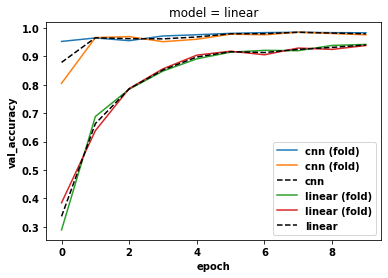

In [13]:
fig, ax = plt.subplots()
for name, g in xdata.groupby("model"):
    g.val_accuracy[:, 0].plot.line(x="epoch", label=f"{name} (fold)", ax=ax)
    g.val_accuracy[:, 0].mean("fold").plot.line(x="epoch", label=name, ax=ax, linestyle="--", color="k")
plt.legend()

## Robustness Curve

In [14]:
from rai_toolbox.mushin import load_from_checkpoint
def load_model_from_experiment(exp_dir: Union[Path, str]):
    exp_dir = Path(exp_dir)
    exp_cfg = exp_dir / ".hydra/config.yaml"
    assert exp_cfg.exists()
    exp_cfg = load_from_yaml(exp_cfg)
    model = instantiate(exp_cfg.model)

    # get path to model checkpoint in experiment directory
    # and load to model
    ckpts = list(exp_dir.glob("**/*.ckpt"))
    assert len(ckpts) == 1
    ckpt = ckpts[0]
    load_from_checkpoint(
        model,
        ckpt=ckpt,
        weights_key="state_dict",
        weights_key_strip="model.",
    )

    return model

TestConfig = make_config(
    defaults = [
        "_self_",
        {"optimizer": "l2pgd"},
    ],
    data_dir = "${oc.env:HOME}/.torch/data",
    exp_dir=MISSING,
    trainer=TrainerCfg,
    module=EvalPLModule,
    model=builds(load_model_from_experiment, exp_dir="${exp_dir}"),
    perturber=Perturber,
    optimizer=MISSING,
    epsilon=0.0,
    steps=10,
)

In [15]:
class ExperimentRobustnessCurve(RobustnessCurve):
    @staticmethod
    def evaluation_task(trainer: Trainer, module: LightningModule):
        trainer.test(module)
        return tr.load("test_metrics.pt")

    def _load_exp_overrides(self, working_dir: Union[str, Path], config_dir: str = ".hydra"):
        ################################################
        # Load multirun values from experiment directory
        ################################################
        multirun_cfg = Path(working_dir) / "multirun.yaml"
        assert (
            multirun_cfg.exists()
        ), "Working directory does not contain `multirun.yaml` file.  Be sure to use the value of the Hydra sweep directory for the workflow"

        self._exp_multirun_task_overrides = defaultdict(list)
        overrides = load_from_yaml(multirun_cfg).hydra.overrides.task
        for o in overrides:
            k, v = o.split("=")
            if k == "exp_dir":
                dirs = v.split(",")
                for dir in dirs:
                    overrides = load_from_yaml(
                        Path(dir) / f"{config_dir}/overrides.yaml"
                    )
                    output = self._parse_overrides(overrides)

                    for ko, vo in output.items():
                        self._exp_multirun_task_overrides[ko].append(vo)


                break

        return self

    def jobs_post_process(self):
        super().jobs_post_process()
        self._load_exp_overrides(self.working_dir)

    def load_from_dir(self,
        working_dir: Union[Path, str],
        config_dir: str = ".hydra",
        metrics_filename: str = "test_metrics.pt",
    ) -> "ExperimentRobustnessCurve":
        super().load_from_dir(working_dir=working_dir, config_dir=config_dir, metrics_filename=metrics_filename)
        self._load_exp_overrides(working_dir=working_dir, config_dir=config_dir)
        return self

    def to_xarray(self, non_multirun_params_as_singleton_dims: bool = False):
        xdata = super().to_xarray(non_multirun_params_as_singleton_dims=non_multirun_params_as_singleton_dims)

        ##################################
        # Add multirun coordinates to data
        ##################################
        exp_dir = xdata.coords["exp_dir"]
        coords = {}
        for k, v in self._exp_multirun_task_overrides.items():
            if len(v) == len(exp_dir):
                uv = list(set(np.unique(v)))
                if len(uv) > 1 or non_multirun_params_as_singleton_dims:
                    coords[k] = (["exp_dir"], v)

        return xdata.assign_coords(coords)

In [16]:
exp_dir = [m.parent for m in kfold_task.working_dir.absolute().glob("**/fit_metrics.pt")]
exp_dir

[PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3')]

In [17]:
robustness_curve_task = ExperimentRobustnessCurve(TestConfig)
robustness_curve_task.run(epsilon=[0,1,2], exp_dir=multirun(exp_dir), overrides=["hydra.sweep.dir=outputs/robustness_curves"])

## You can load an old experiment
# robustness_curve_task = ExperimentRobustnessCurve().load_from_dir("multirun/2022-05-11/12-31-52")

[2022-05-11 13:04:02,098][HYDRA] Launching 12 jobs locally
[2022-05-11 13:04:02,099][HYDRA] 	#0 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0 epsilon=0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:02,281][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9611999988555908
  test_adversarial_loss      0.129347562789917
   test_clean_accuracy      0.9611999988555908
        test_loss           0.12934757769107819
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:04,460][HYDRA] 	#1 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0 epsilon=1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:04,681][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.25940001010894775
  test_adversarial_loss      3.049077033996582
   test_clean_accuracy      0.9611999988555908
        test_loss            3.049077033996582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:06,545][HYDRA] 	#2 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0 epsilon=2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:06,812][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy        0.009700000286102295
  test_adversarial_loss     10.127716064453125
   test_clean_accuracy      0.9611999988555908
        test_loss           10.127716064453125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:08,712][HYDRA] 	#3 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1 epsilon=0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:08,910][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9876000285148621
  test_adversarial_loss     0.03701438754796982
   test_clean_accuracy      0.9876000285148621
        test_loss           0.03701438754796982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:11,366][HYDRA] 	#4 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1 epsilon=1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:11,553][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/4/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.20589999854564667
  test_adversarial_loss     3.6058425903320312
   test_clean_accuracy      0.9876000285148621
        test_loss           3.6058430671691895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:14,404][HYDRA] 	#5 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1 epsilon=2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:14,626][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/5/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.0
  test_adversarial_loss     14.294275283813477
   test_clean_accuracy      0.9876000285148621
        test_loss           14.294275283813477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:17,301][HYDRA] 	#6 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2 epsilon=0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:17,486][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/6/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.953499972820282
  test_adversarial_loss     0.15187175571918488
   test_clean_accuracy       0.953499972820282
        test_loss           0.15187174081802368
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:19,473][HYDRA] 	#7 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2 epsilon=1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:19,709][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/7/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.20759999752044678
  test_adversarial_loss     3.3496930599212646
   test_clean_accuracy       0.953499972820282
        test_loss           3.3496930599212646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:21,583][HYDRA] 	#8 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2 epsilon=2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:21,824][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/8/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy        0.009499999694526196
  test_adversarial_loss     10.279022216796875
   test_clean_accuracy       0.953499972820282
        test_loss           10.279022216796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:23,848][HYDRA] 	#9 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3 epsilon=0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:24,069][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/9/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9796000123023987
  test_adversarial_loss     0.05958341062068939
   test_clean_accuracy      0.9796000123023987
        test_loss           0.05958341062068939
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:26,866][HYDRA] 	#10 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3 epsilon=1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:27,017][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/10/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.1200999990105629
  test_adversarial_loss      5.033505916595459
   test_clean_accuracy      0.9796000123023987
        test_loss            5.033504962921143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2022-05-11 13:04:29,527][HYDRA] 	#11 : exp_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3 epsilon=2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2022-05-11 13:04:29,760][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/11/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy       0.00019999999494757503
  test_adversarial_loss     17.071868896484375
   test_clean_accuracy      0.9796000123023987
        test_loss           17.071868896484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
robustness_curve_task.working_dir

PosixPath('outputs/robustness_curves')

In [19]:
rdata = robustness_curve_task.to_xarray()
rdata

<xarray.Dataset>
Dimensions:                (exp_dir: 4, epsilon: 3)
Coordinates:
  * exp_dir                (exp_dir) <U97 '/home/justin_goodwin/projects/raid...
  * epsilon                (epsilon) int64 0 1 2
    fold                   (exp_dir) int64 0 0 1 1
    model                  (exp_dir) <U6 'linear' 'cnn' 'linear' 'cnn'
Data variables:
    test_clean_accuracy    (exp_dir, epsilon) float64 0.9612 0.9612 ... 0.9796
    test_adversarial_loss  (exp_dir, epsilon) float64 0.1293 3.049 ... 17.07
    test_loss              (exp_dir, epsilon) float64 0.1293 3.049 ... 17.07
    test_accuracy          (exp_dir, epsilon) float64 0.9612 0.2594 ... 0.0002

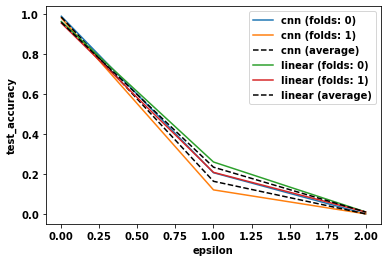

In [20]:
fig, ax = plt.subplots()
for name, g in rdata.groupby("model"):
    for fold, gf in g.groupby("fold"):
        gf.test_accuracy.plot.line(x="epsilon", label=f"{name} (folds: {fold})", ax=ax)
    g.test_accuracy.mean("exp_dir").plot.line(x="epsilon", label=f"{name} (average)", ax=ax, linestyle="--", color="k")

plt.legend()